# Smoothed Disperser Attenuation study for HD205905


Study the true transmission wrt transmission in simulatio 

- author Sylvie Dagoret-Campagne
- creation date : May 2018
- affliliation : CNRS/IN2P3
- project : DESC-LSST

- need to increase the number of files to be open:

    ulimit -a
    
    ulimit -n 2048
    
    ulimit -Sn 10000

In [289]:
!ulimit -a

core file size          (blocks, -c) 0
data seg size           (kbytes, -d) unlimited
file size               (blocks, -f) unlimited
max locked memory       (kbytes, -l) unlimited
max memory size         (kbytes, -m) unlimited
open files                      (-n) 2048
pipe size            (512 bytes, -p) 1
stack size              (kbytes, -s) 8192
cpu time               (seconds, -t) unlimited
max user processes              (-u) 1418
virtual memory          (kbytes, -v) unlimited


## Setup

### Notebook style

In [290]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

### import

In [291]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
%matplotlib inline
import sys
import os
import pandas as pd
import glob
from matplotlib.backends.backend_pdf import PdfPages 

In [292]:
from scipy import interpolate

In [293]:
import seaborn as sns

In [294]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Figure style

In [295]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 10),   #defines the default image size
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [296]:
plt.rcParams.update({'figure.max_open_warning': 0}) # to see a large number of files

## Initialisation

### Spectractor

In [297]:
PATH_SPECTRACTOR='../../../Spectractor'
PATH_SPECTRACTORSIM='../../../SpectractorSim'
PATH_SPECTRACTORANAATM='../../../SpectractorAnaAtm/common_tools'
PATH_GMAOMERRA='../../merra2'

In [298]:
sys.path.append(PATH_SPECTRACTOR)
sys.path.append(PATH_SPECTRACTORSIM)
sys.path.append(PATH_SPECTRACTORANAATM)
sys.path.append(PATH_GMAOMERRA)

In [299]:
from spectractor import *
from spectractorsim import *
from libspecana import *

## Input spectra

### LogBook

In [300]:
file_logbook_csv=os.path.join(PATH_SPECTRACTOR,'ctiofulllogbook_jun2017_v4.csv')

In [301]:
df_ctio_lbk=pd.read_csv(file_logbook_csv,sep=';')

In [302]:
df_ctio_lbk.columns

Index([u'Unnamed: 0', u'date', u'subdir', u'index', u'object', u'filter',
       u'disperser', u'airmass', u'exposure', u'focus', u'seeing', u'P', u'T',
       u'RH', u'W', u'file', u'Obj-posXpix', u'Obj-posYpix', u'Dx', u'Dy',
       u'comment', u'skip'],
      dtype='object')

In [303]:
df_ctio_lbk=df_ctio_lbk.reindex(columns=['date','index','P','T','RH','airmass','seeing','exposure','object','filter','disperser','focus','W','subdir','file']).set_index('date').sort_index()

### Spectra Data

In [304]:
home=os.getenv('HOME')

In [305]:
path_data=os.path.join(home,'DATA/CTIODataJune2017_reduced_RG715_v2_prod1')
#path_data=os.path.join('/sps/lsst/data/AtmosphericCalibration','CTIODataJune2017_reduced_RG715_v2_prod1')

In [306]:
All_Subdirs=np.array(['data_28may17','data_29may17','data_30may17','data_31may17','data_01jun17','data_02jun17',
            'data_03jun17','data_04jun17','data_06jun17','data_08jun17','data_09jun17','data_10jun17',
            'data_12jun17','data_13jun17'])

In [307]:
Flag_Photometric_Nights=np.array([False,False,True,False,False,False,False,False,False,True,False,True,True,False])

In [308]:
photometric_indexes=np.where(Flag_Photometric_Nights)[0]

In [309]:
print 'Photometric indexes : ',photometric_indexes

Photometric indexes :  [ 2  9 11 12]


In [310]:
print 'Photometric nights : ',All_Subdirs[photometric_indexes]

Photometric nights :  ['data_30may17' 'data_08jun17' 'data_10jun17' 'data_12jun17']


### Sim spectra

In [311]:
PATH_SPECTRACTORSIM

'../../../SpectractorAnaAtm/common_tools/../../SpectractorSim'

In [312]:
# laptop:
path_sim=os.path.join(PATH_SPECTRACTORSIM,'sim_prod/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra')
# CCIN2P3:
#path_sim=PATH_SPECTRACTORSIM+'/sim_prod/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra'
# Office desktop
home=os.getenv('HOME')
path_sim=os.path.join(home,'DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra')

In [313]:
path_sim

'/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra'

## Selection of night

In [314]:
date="20170530"

In [315]:
idx_sel_subdir=2

In [316]:
SelectTagRe='^reduc_%s_([0-9]+)_spectrum.fits$' % (date)

### Logbook

In [317]:
all_obs=df_ctio_lbk.loc[(df_ctio_lbk["subdir"]==All_Subdirs[idx_sel_subdir])].sort_index()

In [318]:
all_obs_extr=all_obs[["index","object"]]

### Wavelength correction

In [319]:
FLAG_WL_CORRECTION=True # specify if correction on wavelength can be performed from input file
file_wavelengthshift="../wavelength_shift.csv"
wlshift=pd.read_csv(file_wavelengthshift)

In [320]:
wlshift.head()

index   wlshift
0     57 -6.633933
1     58 -3.083037
2     60 -8.383797
3     61 -2.846134
4     62 -5.646836

### path for spectra

In [321]:
path_spectra=os.path.join(path_data,All_Subdirs[idx_sel_subdir])
path_spectrasim=os.path.join(path_sim,All_Subdirs[idx_sel_subdir])

### find filename for data spectra

In [322]:
search_string=os.path.join(path_spectra,'*.fits')
all_spectrafiles=glob.glob(search_string)
all_spectrafiles=sorted(all_spectrafiles)

### extract the index from the data spectra filename

In [323]:
#SelectTagRe='^reduc_%s_([0-9]+)_spectrum.fits$' % (date)
all_sel_indexes=[]
for ffn in all_spectrafiles:
    all_sel_indexes.append(get_index_from_filename(ffn,SelectTagRe))
all_sel_indexes=np.array(all_sel_indexes)    

### extract the logbook rows corrsponding to the spectra

- use the indexes obtained to extract the relevant rows from the logbook

In [324]:
sel_obs=all_obs.loc[all_obs['index'].isin(all_sel_indexes)]

In [325]:
sel_obs.head()

index    P    T  RH airmass seeing exposure  \
date                                                                   
2017-05-31T00:00:26.147     57  783  9,3  26   1,053   1,14       60   
2017-05-31T00:02:18.596     58  783  9,3  26   1,051   0,94       60   
2017-05-31T00:06:14.000     60  783  9,1  26   1,047  1,018       60   
2017-05-31T00:08:06.454     61  783  9,2  26   1,045  0,939       60   
2017-05-31T00:09:58.852     62  783  9,1  26   1,044  0,846       60   

                           object filter disperser  focus    W        subdir  \
date                                                                           
2017-05-31T00:00:26.147  HD111980    dia    Ron400  12450  5,7  data_30may17   
2017-05-31T00:02:18.596  HD111980    dia   Thor300  12450  5,5  data_30may17   
2017-05-31T00:06:14.000  HD111980    dia    Ron400  12450  5,7  data_30may17   
2017-05-31T00:08:06.454  HD111980    dia   Thor300  12450  5,5  data_30may17   
2017-05-31T00:09:58.852  HD111980    dia   HoloPhP  12450  5,8  data_30may17   

                                            file  
date                                              
2017-05-31T00:00:26.147  reduc_20170530_057.fits  
2017-05-31T00:02:18.596  reduc_20170530_058.fits  
2017-05-31T00:06:14.000  reduc_20170530_060.fits  
2017-05-31T00:08:06.454  reduc_20170530_061.fits  
2017-05-31T00:09:58.852  reduc_20170530_062.fits

In [326]:
sel_obs.tail()

index    P     T  RH airmass seeing exposure  \
date                                                                    
2017-05-31T10:33:46.896    280  782    11  20   1,018  0,793       60   
2017-05-31T10:35:39.245    281  782  11,2  20   1,019  0,793       60   
2017-05-31T10:37:31.598    282  782    11  20   1,021  0,793       60   
2017-05-31T10:39:24.046    283  782    11  20   1,022  0,793      120   
2017-05-31T10:42:16.450    284  782    11  20   1,024  0,793      120   

                           object filter disperser  focus     W        subdir  \
date                                                                            
2017-05-31T10:33:46.896  HD205905    dia    Ron400  12400  14,5  data_30may17   
2017-05-31T10:35:39.245  HD205905    dia   Thor300  12400  13,1  data_30may17   
2017-05-31T10:37:31.598  HD205905    dia   HoloPhP  12400  12,5  data_30may17   
2017-05-31T10:39:24.046  HD205905    dia  HoloPhAg  12400  12,8  data_30may17   
2017-05-31T10:42:16.450  HD205905    dia  HoloAmAg  12400  13,2  data_30may17   

                                            file  
date                                              
2017-05-31T10:33:46.896  reduc_20170530_280.fits  
2017-05-31T10:35:39.245  reduc_20170530_281.fits  
2017-05-31T10:37:31.598  reduc_20170530_282.fits  
2017-05-31T10:39:24.046  reduc_20170530_283.fits  
2017-05-31T10:42:16.450  reduc_20170530_284.fits

### Quick view on the kind of sources

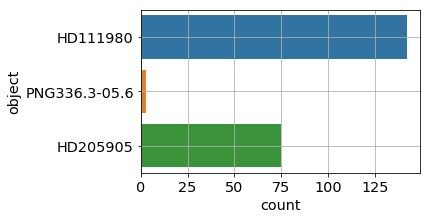

In [327]:
plt.figure(figsize=(5,3))
sns.countplot(y='object', data=sel_obs)
plt.grid(True)

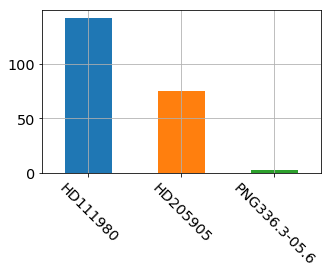

In [328]:
plt.figure(figsize=(5,3))
sel_obs['object'].value_counts().plot(kind='bar',rot=0)
plt.xticks(rotation=-45)
plt.grid(True)

### Remove bad spectra

In [329]:
bad_obs_0=sel_obs.loc[sel_obs['index'].isin([57])]

In [330]:
bad_obs_0

index    P    T  RH airmass seeing exposure  \
date                                                                   
2017-05-31T00:00:26.147     57  783  9,3  26   1,053   1,14       60   

                           object filter disperser  focus    W        subdir  \
date                                                                           
2017-05-31T00:00:26.147  HD111980    dia    Ron400  12450  5,7  data_30may17   

                                            file  
date                                              
2017-05-31T00:00:26.147  reduc_20170530_057.fits

### Remove bad sources

- remove star **PNG336.3-05.6**

In [331]:
bad_obs=sel_obs.loc[sel_obs['object'].isin(['PNG336.3-05.6','HD111980'])]
bad_indexes=bad_obs["index"]

In [332]:
bad_obs

index    P    T  RH airmass seeing exposure  \
date                                                                   
2017-05-31T00:00:26.147     57  783  9,3  26   1,053   1,14       60   
2017-05-31T00:02:18.596     58  783  9,3  26   1,051   0,94       60   
2017-05-31T00:06:14.000     60  783  9,1  26   1,047  1,018       60   
2017-05-31T00:08:06.454     61  783  9,2  26   1,045  0,939       60   
2017-05-31T00:09:58.852     62  783  9,1  26   1,044  0,846       60   
2017-05-31T00:11:51.243     63  783  8,9  26   1,042   0,83      120   
2017-05-31T00:14:43.647     64  783  8,9  26    1,04   0,74      120   
2017-05-31T00:17:36.001     65  783  8,8  26   1,037  0,771       60   
2017-05-31T00:19:28.503     66  783  8,8  26   1,036  0,715       60   
2017-05-31T00:21:20.951     67  783  8,7  26   1,035  0,954       60   
2017-05-31T00:23:13.357     68  783  8,6  26   1,033  0,714      120   
2017-05-31T00:26:05.798     69  783  8,7  26   1,032  0,714      120   
2017-05-31T00:28:58.154     70  783  8,7  26    1,03   0,82       60   
2017-05-31T00:30:50.597     71  783  8,6  26   1,029  0,843       60   
2017-05-31T00:32:43.005     72  783  8,6  26   1,028  0,741       60   
2017-05-31T00:34:35.343     73  783  8,5  27   1,027  0,744      120   
2017-05-31T00:37:27.804     74  783  8,6  27   1,026  0,821      120   
2017-05-31T00:40:20.202     75  783  8,6  26   1,025  0,856       60   
2017-05-31T00:42:12.549     76  783  8,6  26   1,024   0,71       60   
2017-05-31T00:44:04.958     77  783  8,6  26   1,024  0,785       60   
2017-05-31T00:45:57.400     78  783  8,6  26   1,023  0,708      120   
2017-05-31T00:48:49.851     79  783  8,6  26   1,022  0,704      120   
2017-05-31T00:51:42.249     80  783  8,5  26   1,022  0,711       60   
2017-05-31T00:53:34.704     81  783  8,6  26   1,021  0,719       60   
2017-05-31T00:55:27.048     82  783  8,8  26   1,021  0,728       60   
2017-05-31T00:57:20.103     83  783  8,9  25   1,021  0,731      120   
2017-05-31T01:00:12.403     84  783    9  25   1,021  0,713      120   
2017-05-31T01:03:04.652     85  783    9  25   1,021  0,638       60   
2017-05-31T01:04:56.895     86  783    9  25   1,021  0,629       60   
2017-05-31T01:06:49.302     87  783    9  25   1,021  0,629       60   
...                        ...  ...  ...  ..     ...    ...      ...   
2017-05-31T04:21:56.702    173  783  8,7  24   1,455  1,063      120   
2017-05-31T04:24:49.096    174  783  8,7  24   1,472  0,991      120   
2017-05-31T04:27:41.495    175  783  8,8  24    1,49  0,958       60   
2017-05-31T04:29:33.751    176  783  8,8  24   1,501  0,903       60   
2017-05-31T04:31:26.199    177  783  8,8  24   1,513  0,783       60   
2017-05-31T04:33:18.602    178  783  8,7  24   1,526   0,77      120   
2017-05-31T04:36:11.102    179  783  8,7  24   1,545   0,77      120   
2017-05-31T04:39:03.498    180  783  8,6  24   1,565  0,658       60   
2017-05-31T04:40:55.900    181  783  8,6  24   1,579  0,742       60   
2017-05-31T04:42:48.297    182  783  8,7  24   1,592  0,816       60   
2017-05-31T04:44:40.547    183  783  8,8  24   1,607  0,654      120   
2017-05-31T04:47:32.999    184  783  8,9  24   1,629  0,704      120   
2017-05-31T04:50:25.404    185  783    9  24   1,652  0,662       60   
2017-05-31T04:52:17.795    186  783    9  24   1,667   0,64       60   
2017-05-31T04:54:10.199    187  783  9,1  24   1,683  0,618       60   
2017-05-31T04:56:02.504    188  783  9,3  24     1,7  0,614      120   
2017-05-31T04:58:54.903    189  783  9,2  24   1,725  0,641      120   
2017-05-31T05:01:47.196    190  783  9,2  23   1,752   0,63       60   
2017-05-31T05:03:39.595    191  783  9,3  23    1,77  0,601       60   
2017-05-31T05:05:32.008    192  783  9,3  23   1,789  0,521       60   
2017-05-31T05:07:24.403    193  783  9,3  23   1,807  0,531      120   
2017-05-31T05:10:16.753    194  783  9,2  23   1,837  0,567      120   
2017-05-31T05:13:09.206    195  783  9,2  23   1,869  0,574      

In [333]:
bad_indexes=bad_obs.loc[:,"index"]

In [334]:
bad_indexes.index

Index([u'2017-05-31T00:00:26.147', u'2017-05-31T00:02:18.596',
       u'2017-05-31T00:06:14.000', u'2017-05-31T00:08:06.454',
       u'2017-05-31T00:09:58.852', u'2017-05-31T00:11:51.243',
       u'2017-05-31T00:14:43.647', u'2017-05-31T00:17:36.001',
       u'2017-05-31T00:19:28.503', u'2017-05-31T00:21:20.951',
       ...
       u'2017-05-31T05:07:24.403', u'2017-05-31T05:10:16.753',
       u'2017-05-31T05:13:09.206', u'2017-05-31T05:15:01.551',
       u'2017-05-31T05:16:53.954', u'2017-05-31T05:18:46.349',
       u'2017-05-31T05:21:38.803', u'2017-05-31T05:56:35.901',
       u'2017-05-31T06:05:21.701', u'2017-05-31T07:03:12.652'],
      dtype='object', name=u'date', length=145)

In [335]:
bad_indexes.values

array([ 57,  58,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,
        71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
        84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
        97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
       110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122,
       123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135,
       136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148,
       149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161,
       162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174,
       175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187,
       188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200,
       201, 205])

### Concatenate bad obs

In [336]:
bad_obs=pd.concat([bad_obs,bad_obs_0])

In [337]:
bad_obs

index    P    T  RH airmass seeing exposure  \
date                                                                   
2017-05-31T00:00:26.147     57  783  9,3  26   1,053   1,14       60   
2017-05-31T00:02:18.596     58  783  9,3  26   1,051   0,94       60   
2017-05-31T00:06:14.000     60  783  9,1  26   1,047  1,018       60   
2017-05-31T00:08:06.454     61  783  9,2  26   1,045  0,939       60   
2017-05-31T00:09:58.852     62  783  9,1  26   1,044  0,846       60   
2017-05-31T00:11:51.243     63  783  8,9  26   1,042   0,83      120   
2017-05-31T00:14:43.647     64  783  8,9  26    1,04   0,74      120   
2017-05-31T00:17:36.001     65  783  8,8  26   1,037  0,771       60   
2017-05-31T00:19:28.503     66  783  8,8  26   1,036  0,715       60   
2017-05-31T00:21:20.951     67  783  8,7  26   1,035  0,954       60   
2017-05-31T00:23:13.357     68  783  8,6  26   1,033  0,714      120   
2017-05-31T00:26:05.798     69  783  8,7  26   1,032  0,714      120   
2017-05-31T00:28:58.154     70  783  8,7  26    1,03   0,82       60   
2017-05-31T00:30:50.597     71  783  8,6  26   1,029  0,843       60   
2017-05-31T00:32:43.005     72  783  8,6  26   1,028  0,741       60   
2017-05-31T00:34:35.343     73  783  8,5  27   1,027  0,744      120   
2017-05-31T00:37:27.804     74  783  8,6  27   1,026  0,821      120   
2017-05-31T00:40:20.202     75  783  8,6  26   1,025  0,856       60   
2017-05-31T00:42:12.549     76  783  8,6  26   1,024   0,71       60   
2017-05-31T00:44:04.958     77  783  8,6  26   1,024  0,785       60   
2017-05-31T00:45:57.400     78  783  8,6  26   1,023  0,708      120   
2017-05-31T00:48:49.851     79  783  8,6  26   1,022  0,704      120   
2017-05-31T00:51:42.249     80  783  8,5  26   1,022  0,711       60   
2017-05-31T00:53:34.704     81  783  8,6  26   1,021  0,719       60   
2017-05-31T00:55:27.048     82  783  8,8  26   1,021  0,728       60   
2017-05-31T00:57:20.103     83  783  8,9  25   1,021  0,731      120   
2017-05-31T01:00:12.403     84  783    9  25   1,021  0,713      120   
2017-05-31T01:03:04.652     85  783    9  25   1,021  0,638       60   
2017-05-31T01:04:56.895     86  783    9  25   1,021  0,629       60   
2017-05-31T01:06:49.302     87  783    9  25   1,021  0,629       60   
...                        ...  ...  ...  ..     ...    ...      ...   
2017-05-31T04:24:49.096    174  783  8,7  24   1,472  0,991      120   
2017-05-31T04:27:41.495    175  783  8,8  24    1,49  0,958       60   
2017-05-31T04:29:33.751    176  783  8,8  24   1,501  0,903       60   
2017-05-31T04:31:26.199    177  783  8,8  24   1,513  0,783       60   
2017-05-31T04:33:18.602    178  783  8,7  24   1,526   0,77      120   
2017-05-31T04:36:11.102    179  783  8,7  24   1,545   0,77      120   
2017-05-31T04:39:03.498    180  783  8,6  24   1,565  0,658       60   
2017-05-31T04:40:55.900    181  783  8,6  24   1,579  0,742       60   
2017-05-31T04:42:48.297    182  783  8,7  24   1,592  0,816       60   
2017-05-31T04:44:40.547    183  783  8,8  24   1,607  0,654      120   
2017-05-31T04:47:32.999    184  783  8,9  24   1,629  0,704      120   
2017-05-31T04:50:25.404    185  783    9  24   1,652  0,662       60   
2017-05-31T04:52:17.795    186  783    9  24   1,667   0,64       60   
2017-05-31T04:54:10.199    187  783  9,1  24   1,683  0,618       60   
2017-05-31T04:56:02.504    188  783  9,3  24     1,7  0,614      120   
2017-05-31T04:58:54.903    189  783  9,2  24   1,725  0,641      120   
2017-05-31T05:01:47.196    190  783  9,2  23   1,752   0,63       60   
2017-05-31T05:03:39.595    191  783  9,3  23    1,77  0,601       60   
2017-05-31T05:05:32.008    192  783  9,3  23   1,789  0,521       60   
2017-05-31T05:07:24.403    193  783  9,3  23   1,807  0,531      120   
2017-05-31T05:10:16.753    194  783  9,2  23   1,837  0,567      120   
2017-05-31T05:13:09.206    195  783  9,2  23   1,869  0,574       60   
2017-05-31T05:15:01.551    196  783  9,3  23    1,89  0,618      

In [338]:
bad_obs.sort_values(by="index",inplace=True)

In [339]:
bad_indexes=bad_obs.loc[:,"index"]

In [340]:
bad_indexes.index

Index([u'2017-05-31T00:00:26.147', u'2017-05-31T00:00:26.147',
       u'2017-05-31T00:02:18.596', u'2017-05-31T00:06:14.000',
       u'2017-05-31T00:08:06.454', u'2017-05-31T00:09:58.852',
       u'2017-05-31T00:11:51.243', u'2017-05-31T00:14:43.647',
       u'2017-05-31T00:17:36.001', u'2017-05-31T00:19:28.503',
       ...
       u'2017-05-31T05:07:24.403', u'2017-05-31T05:10:16.753',
       u'2017-05-31T05:13:09.206', u'2017-05-31T05:15:01.551',
       u'2017-05-31T05:16:53.954', u'2017-05-31T05:18:46.349',
       u'2017-05-31T05:21:38.803', u'2017-05-31T05:56:35.901',
       u'2017-05-31T06:05:21.701', u'2017-05-31T07:03:12.652'],
      dtype='object', name=u'date', length=146)

In [341]:
bad_indexes.values

array([ 57,  57,  58,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
        70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,
        83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,
        96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108,
       109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121,
       122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134,
       135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147,
       148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160,
       161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173,
       174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186,
       187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199,
       200, 201, 205])

- keep stars **HD111980**, **HD205905**

In [342]:
sel2_obs=sel_obs.loc[sel_obs['object'].isin(['HD205905'])]

In [343]:
sel2_obs=sel2_obs[sel2_obs.index !=57]      # REMOVE 57

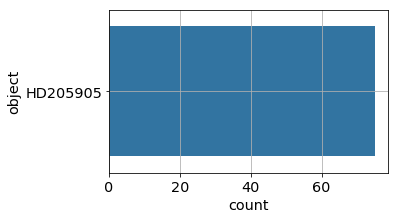

In [344]:
plt.figure(figsize=(5,3))
sns.countplot(y='object', data=sel2_obs)
plt.grid(True)

#### Make a list of the object names

In [345]:
list_of_objects=sel2_obs['object'].values

In [346]:
list_of_objects=set(list_of_objects)

In [347]:
list_of_objects=list(list_of_objects)

In [348]:
list_of_objects_str=','.join(list_of_objects)

### find filename for sim spectra

In [349]:
path_sim1=os.path.join(path_spectrasim,'clearsky')
path_sim2=os.path.join(path_spectrasim,'standard')
path_sim3=os.path.join(path_spectrasim,'merra2')

In [350]:
search_string=os.path.join(path_sim1,'*.fits')
all_simspectrafiles1=glob.glob(search_string)
all_simspectrafiles1=sorted(all_simspectrafiles1)

In [351]:
all_simspectrafiles1[:3]

['/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_30may17/clearsky/specsim_20170530_057_spectrum.fits',
 '/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_30may17/clearsky/specsim_20170530_058_spectrum.fits',
 '/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_30may17/clearsky/specsim_20170530_060_spectrum.fits']

In [352]:
search_string=os.path.join(path_sim2,'*.fits')
all_simspectrafiles2=glob.glob(search_string)
all_simspectrafiles2=sorted(all_simspectrafiles2)

In [353]:
all_simspectrafiles2[:3]

['/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_30may17/standard/specsim_20170530_057_spectrum.fits',
 '/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_30may17/standard/specsim_20170530_058_spectrum.fits',
 '/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_30may17/standard/specsim_20170530_060_spectrum.fits']

In [354]:
search_string=os.path.join(path_sim3,'*.fits')
all_simspectrafiles3=glob.glob(search_string)
all_simspectrafiles3=sorted(all_simspectrafiles3)

In [355]:
all_simspectrafiles3[:3]

['/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_30may17/merra2/specsim_20170530_057_spectrum.fits',
 '/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_30may17/merra2/specsim_20170530_058_spectrum.fits',
 '/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_30may17/merra2/specsim_20170530_060_spectrum.fits']

# Remove bad indexes

In [356]:
file_toremove=[]
SelectTagRe='^reduc_%s_([0-9]+)_spectrum.fits$' % (date)
for ffn in all_spectrafiles:
    fn=ffn.split('/')[-1]
    sel_index= int(re.findall(SelectTagRe,fn)[0])
    if sel_index in bad_indexes.values:
        print ' remove ', fn
        file_toremove.append(ffn)
for f in file_toremove:
    all_spectrafiles.remove(f)        

 remove  reduc_20170530_057_spectrum.fits
 remove  reduc_20170530_058_spectrum.fits
 remove  reduc_20170530_060_spectrum.fits
 remove  reduc_20170530_061_spectrum.fits
 remove  reduc_20170530_062_spectrum.fits
 remove  reduc_20170530_063_spectrum.fits
 remove  reduc_20170530_064_spectrum.fits
 remove  reduc_20170530_065_spectrum.fits
 remove  reduc_20170530_066_spectrum.fits
 remove  reduc_20170530_067_spectrum.fits
 remove  reduc_20170530_068_spectrum.fits
 remove  reduc_20170530_069_spectrum.fits
 remove  reduc_20170530_070_spectrum.fits
 remove  reduc_20170530_071_spectrum.fits
 remove  reduc_20170530_072_spectrum.fits
 remove  reduc_20170530_073_spectrum.fits
 remove  reduc_20170530_074_spectrum.fits
 remove  reduc_20170530_075_spectrum.fits
 remove  reduc_20170530_076_spectrum.fits
 remove  reduc_20170530_077_spectrum.fits
 remove  reduc_20170530_078_spectrum.fits
 remove  reduc_20170530_079_spectrum.fits
 remove  reduc_20170530_080_spectrum.fits
 remove  reduc_20170530_081_spectr

In [357]:
file_toremove=[]
SelectTagRe='^specsim_%s_([0-9]+)_spectrum.fits$' % (date)
for ffn in all_simspectrafiles1:
    fn=ffn.split('/')[-1]
    sel_index= int(re.findall(SelectTagRe,fn)[0])
    if sel_index in bad_indexes.values:
        print ' remove ', fn
        file_toremove.append(ffn)
for f in file_toremove:
    all_simspectrafiles1.remove(f)   

 remove  specsim_20170530_057_spectrum.fits
 remove  specsim_20170530_058_spectrum.fits
 remove  specsim_20170530_060_spectrum.fits
 remove  specsim_20170530_061_spectrum.fits
 remove  specsim_20170530_062_spectrum.fits
 remove  specsim_20170530_063_spectrum.fits
 remove  specsim_20170530_064_spectrum.fits
 remove  specsim_20170530_065_spectrum.fits
 remove  specsim_20170530_066_spectrum.fits
 remove  specsim_20170530_067_spectrum.fits
 remove  specsim_20170530_068_spectrum.fits
 remove  specsim_20170530_069_spectrum.fits
 remove  specsim_20170530_070_spectrum.fits
 remove  specsim_20170530_071_spectrum.fits
 remove  specsim_20170530_072_spectrum.fits
 remove  specsim_20170530_073_spectrum.fits
 remove  specsim_20170530_074_spectrum.fits
 remove  specsim_20170530_075_spectrum.fits
 remove  specsim_20170530_076_spectrum.fits
 remove  specsim_20170530_077_spectrum.fits
 remove  specsim_20170530_078_spectrum.fits
 remove  specsim_20170530_079_spectrum.fits
 remove  specsim_20170530_080_sp

In [358]:
file_toremove=[]
SelectTagRe='^specsim_%s_([0-9]+)_spectrum.fits$' % (date)
for ffn in all_simspectrafiles2:
    fn=ffn.split('/')[-1]
    sel_index= int(re.findall(SelectTagRe,fn)[0])
    if sel_index in bad_indexes.values:
        print ' remove ', fn
        file_toremove.append(ffn)
for f in file_toremove:
    all_simspectrafiles2.remove(f)

 remove  specsim_20170530_057_spectrum.fits
 remove  specsim_20170530_058_spectrum.fits
 remove  specsim_20170530_060_spectrum.fits
 remove  specsim_20170530_061_spectrum.fits
 remove  specsim_20170530_062_spectrum.fits
 remove  specsim_20170530_063_spectrum.fits
 remove  specsim_20170530_064_spectrum.fits
 remove  specsim_20170530_065_spectrum.fits
 remove  specsim_20170530_066_spectrum.fits
 remove  specsim_20170530_067_spectrum.fits
 remove  specsim_20170530_068_spectrum.fits
 remove  specsim_20170530_069_spectrum.fits
 remove  specsim_20170530_070_spectrum.fits
 remove  specsim_20170530_071_spectrum.fits
 remove  specsim_20170530_072_spectrum.fits
 remove  specsim_20170530_073_spectrum.fits
 remove  specsim_20170530_074_spectrum.fits
 remove  specsim_20170530_075_spectrum.fits
 remove  specsim_20170530_076_spectrum.fits
 remove  specsim_20170530_077_spectrum.fits
 remove  specsim_20170530_078_spectrum.fits
 remove  specsim_20170530_079_spectrum.fits
 remove  specsim_20170530_080_sp

In [359]:
file_toremove=[]
SelectTagRe='^specsim_%s_([0-9]+)_spectrum.fits$' % (date)
for ffn in all_simspectrafiles3:
    fn=ffn.split('/')[-1]
    sel_index= int(re.findall(SelectTagRe,fn)[0])
    if sel_index in bad_indexes.values:
        print ' remove ', fn
        file_toremove.append(ffn)
for f in file_toremove:
    all_simspectrafiles3.remove(f)

 remove  specsim_20170530_057_spectrum.fits
 remove  specsim_20170530_058_spectrum.fits
 remove  specsim_20170530_060_spectrum.fits
 remove  specsim_20170530_061_spectrum.fits
 remove  specsim_20170530_062_spectrum.fits
 remove  specsim_20170530_063_spectrum.fits
 remove  specsim_20170530_064_spectrum.fits
 remove  specsim_20170530_065_spectrum.fits
 remove  specsim_20170530_066_spectrum.fits
 remove  specsim_20170530_067_spectrum.fits
 remove  specsim_20170530_068_spectrum.fits
 remove  specsim_20170530_069_spectrum.fits
 remove  specsim_20170530_070_spectrum.fits
 remove  specsim_20170530_071_spectrum.fits
 remove  specsim_20170530_072_spectrum.fits
 remove  specsim_20170530_073_spectrum.fits
 remove  specsim_20170530_074_spectrum.fits
 remove  specsim_20170530_075_spectrum.fits
 remove  specsim_20170530_076_spectrum.fits
 remove  specsim_20170530_077_spectrum.fits
 remove  specsim_20170530_078_spectrum.fits
 remove  specsim_20170530_079_spectrum.fits
 remove  specsim_20170530_080_sp

# which filters

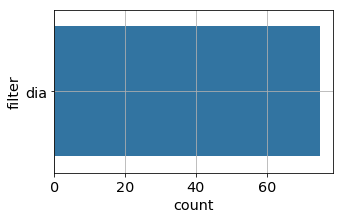

In [360]:
plt.figure(figsize=(5,3))
sns.countplot(y='filter', data=sel2_obs)
plt.grid(True)

# which are the dispersers ?

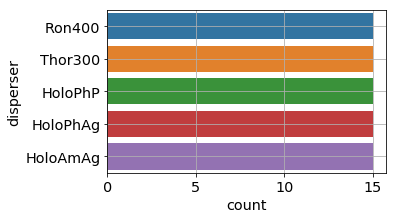

In [361]:
plt.figure(figsize=(5,3))
sns.countplot(y='disperser', data=sel2_obs)
plt.grid(True)

In [362]:
sel_obs_Ron400=sel2_obs.loc[sel2_obs['disperser'].isin(['Ron400'])]

In [363]:
sel_obs_Thor300=sel2_obs.loc[sel2_obs['disperser'].isin(['Thor300'])]

In [364]:
sel_obs_HoloPhP=sel2_obs.loc[sel2_obs['disperser'].isin(['HoloPhP'])]

In [365]:
sel_obs_HoloPhAg=sel2_obs.loc[sel2_obs['disperser'].isin(['HoloPhAg'])]

In [366]:
sel_obs_HoloAmAg=sel2_obs.loc[sel2_obs['disperser'].isin(['HoloAmAg'])]

# Show the spectra

## Show the reconstructed spectra

In [367]:
SearchTagRe='^reduc_%s_([0-9]+)_spectrum.fits$' % (date)
print SearchTagRe

^reduc_20170530_([0-9]+)_spectrum.fits$


### Ronchi 400 spectra

In [368]:
thetitle="Smoothed Reconstructed spectra for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Ronchi400"

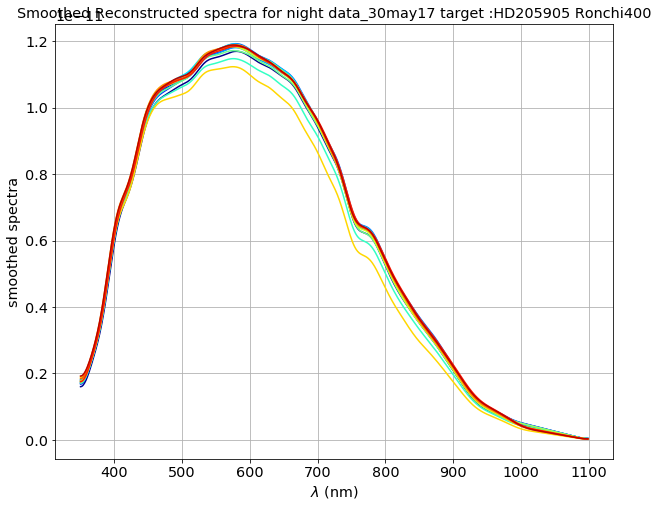

In [369]:
PlotSpectraDataSimSmooth(all_spectrafiles,sel_obs_Ron400,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,Wwidth=51)

### Thor 300

In [370]:
thetitle="Reconstructed smoothed spectra for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Thor300"

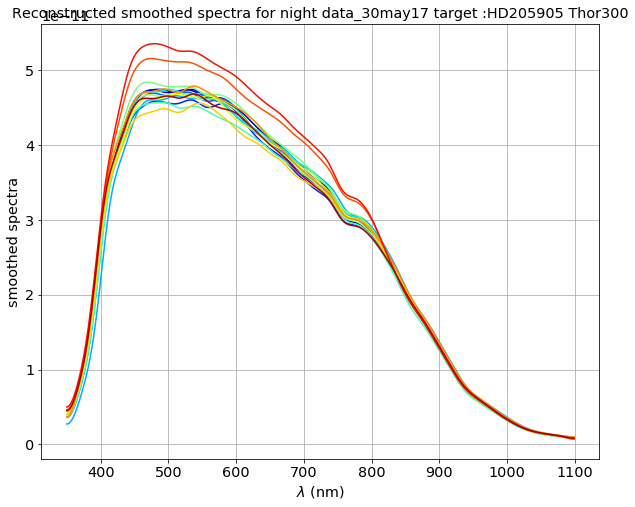

In [371]:
PlotSpectraDataSimSmooth(all_spectrafiles,sel_obs_Thor300,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,Wwidth=51)

### HoloPhP

In [372]:
thetitle="Reconstructed smooth spectra for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloPhP"

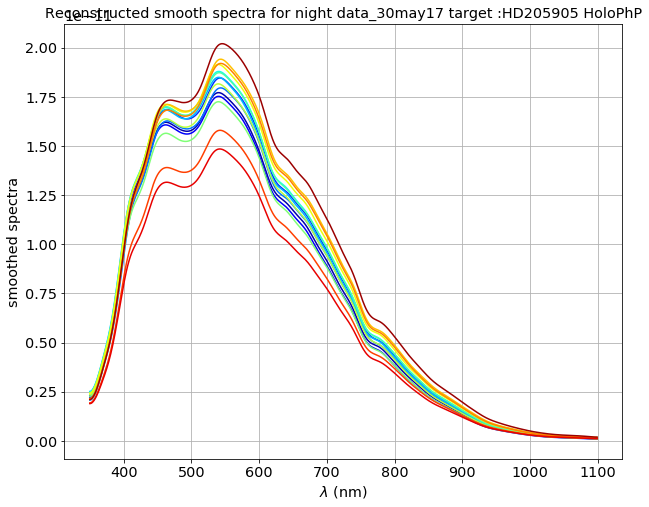

In [373]:
PlotSpectraDataSimSmooth(all_spectrafiles,sel_obs_HoloPhP,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,Wwidth=51)

### HoloPhAg

In [374]:
thetitle="Reconstructed smooth spectra for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloPhAg"

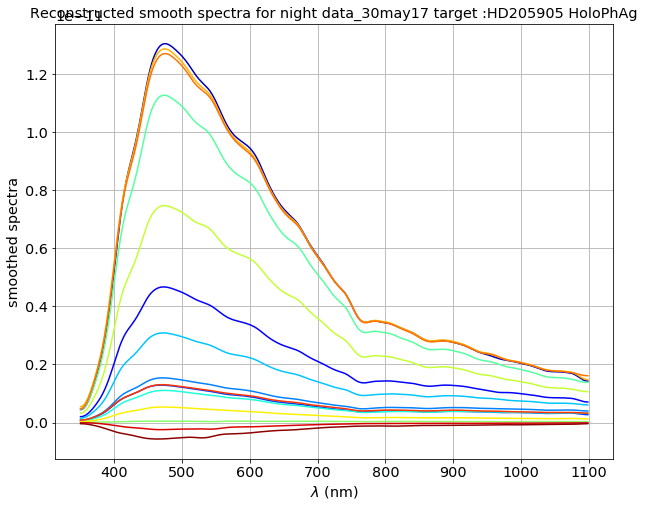

In [375]:
PlotSpectraDataSimSmooth(all_spectrafiles,sel_obs_HoloPhAg,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,Wwidth=51)

### HoloAmAg

In [376]:
thetitle="Reconstructed smoothed spectra for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloAmAg"

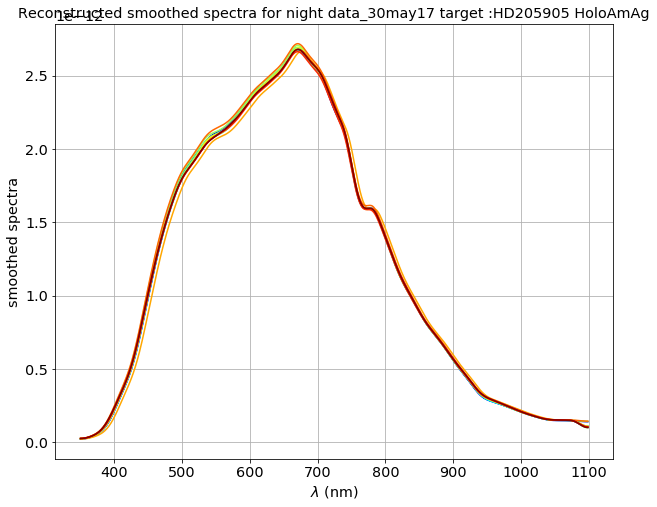

In [377]:
PlotSpectraDataSimSmooth(all_spectrafiles,sel_obs_HoloAmAg,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,Wwidth=51)

## Show the simulated spectra

In [378]:
SearchTagRe='^specsim_%s_([0-9]+)_spectrum.fits$' % (date)

### Clear sky

In [379]:
thetitle="Smoothed sim spectra for night (clearsky) "+All_Subdirs[idx_sel_subdir]+' target :'+list_of_objects_str

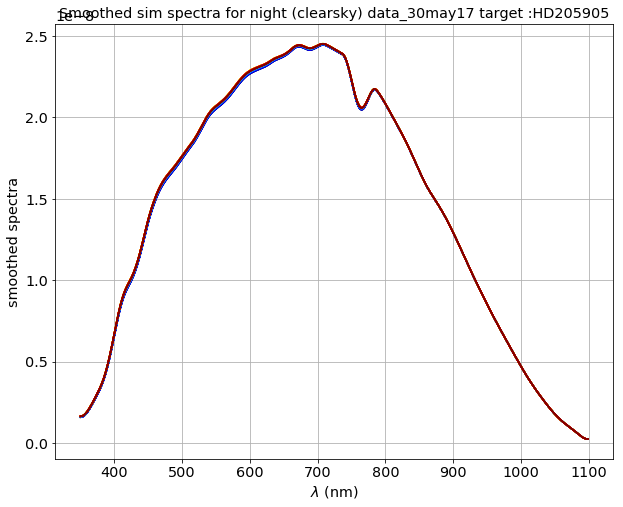

In [380]:
PlotSpectraDataSimSmooth(all_simspectrafiles1,sel2_obs,SearchTagRe,np.zeros(len(wlshift)),thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=False,Wwidth=51)

### standard sky

In [381]:
thetitle="Smoothed sim spectra for night (standard) "+All_Subdirs[idx_sel_subdir]+' target :'+list_of_objects_str

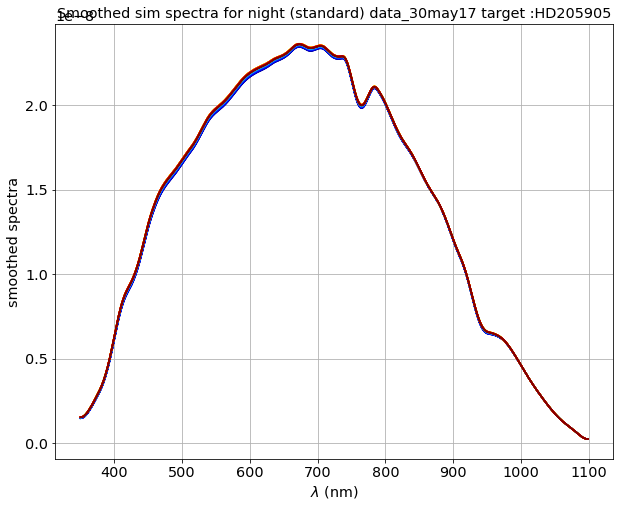

In [382]:
PlotSpectraDataSimSmooth(all_simspectrafiles2,sel2_obs,SearchTagRe,np.zeros(len(wlshift)),thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=False,Wwidth=51)

### merra2 sky

In [383]:
thetitle="Smoothed sim spectra for night (merra2) "+All_Subdirs[idx_sel_subdir]+' target :'+list_of_objects_str

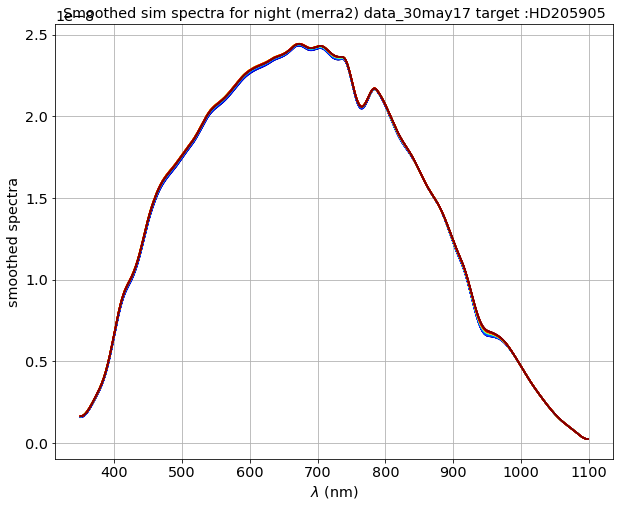

In [384]:
PlotSpectraDataSimSmooth(all_simspectrafiles3,sel2_obs,SearchTagRe,np.zeros(len(wlshift)),thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=False,Wwidth=51)

# Airmass vs image index

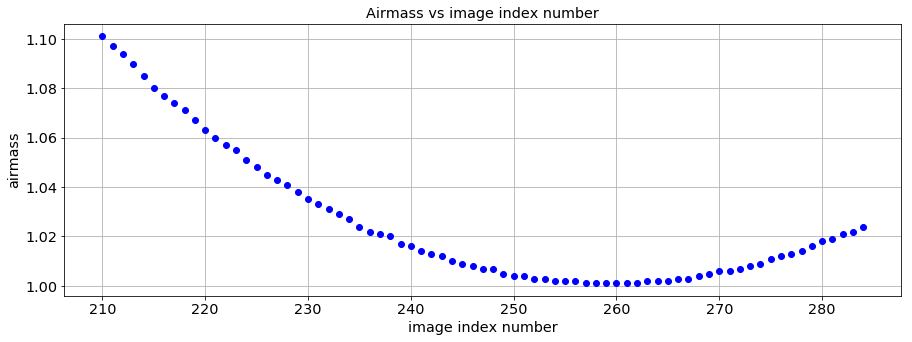

In [385]:
plt.figure(figsize=(15,5))
plt.plot(sel2_obs["index"],Convert_InFloat(sel2_obs["airmass"]),'bo')
plt.xlabel("image index number")
plt.ylabel("airmass")
plt.title('Airmass vs image index number')
plt.grid()

# Attenuation

## Ronchi 400

In [386]:
SearchTagRe='^reduc_%s_([0-9]+)_spectrum.fits$' % (date)

In [387]:
thetitle="Attenuation 400-600 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Ronchi400"

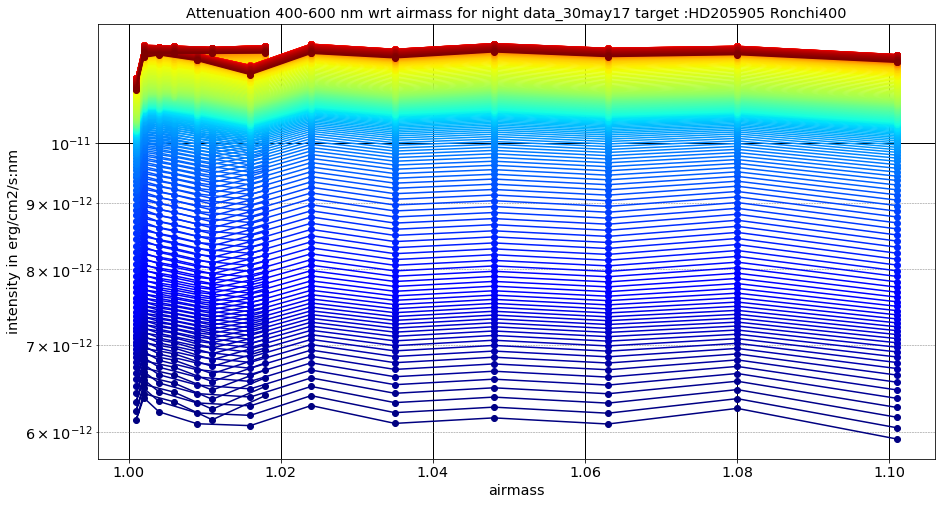

In [388]:
PlotSpectraDataSimAttenuationSmooth(all_spectrafiles,sel_obs_Ron400,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=400,XMAX=1000.,YMIN=0,YMAX=0,ZMIN=400,ZMAX=600,Wwidth=51)   

In [389]:
thetitle="Binned Attenuation 400-600 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Ronchi400"

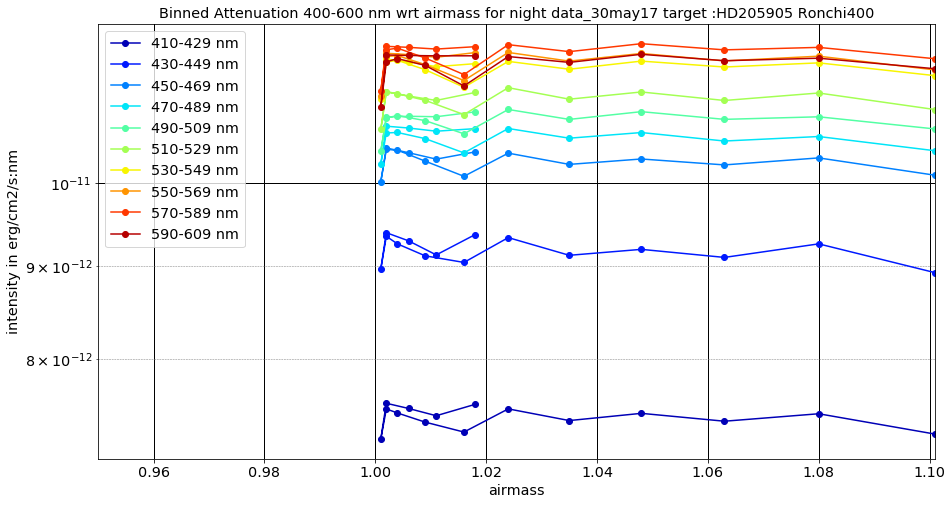

In [390]:
PlotSpectraDataSimAttenuationSmoothBin(all_spectrafiles,sel_obs_Ron400,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=0.95,XMAX=0,YMIN=0,YMAX=0,ZMIN=400,ZMAX=600,Wwidth=21,Bwidth=20)   

In [391]:
thetitle="Binned Attenuation 600-1000 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Ronchi400"

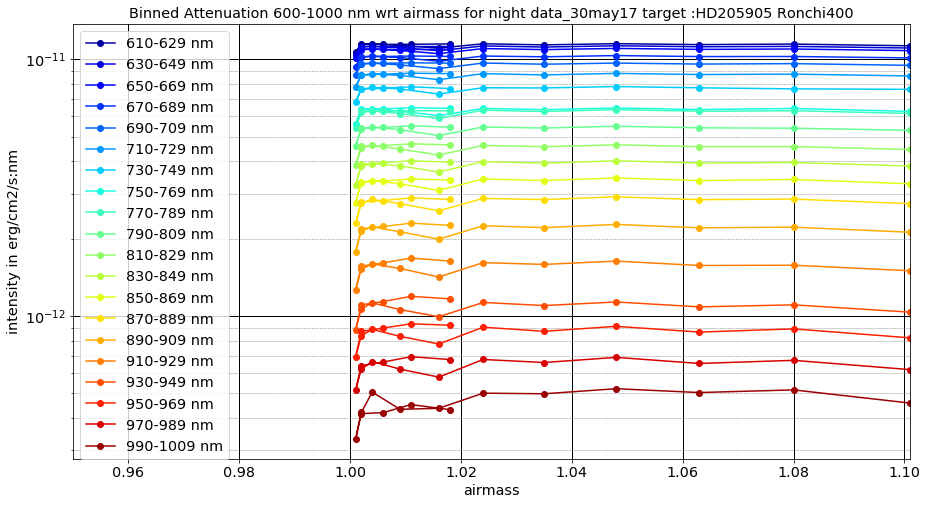

In [392]:
PlotSpectraDataSimAttenuationSmoothBin(all_spectrafiles,sel_obs_Ron400,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=0.95,XMAX=0,YMIN=0,YMAX=0,ZMIN=600,ZMAX=1000,Wwidth=21,Bwidth=20) 

## Thor300

In [393]:
thetitle="Attenuation 400-600 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Thor300"

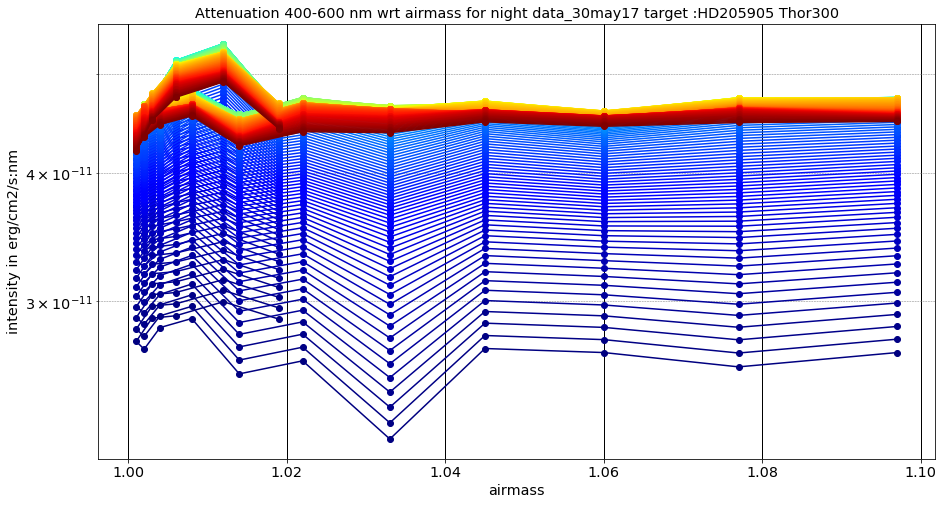

In [394]:
PlotSpectraDataSimAttenuationSmooth(all_spectrafiles,sel_obs_Thor300,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=400,XMAX=1000.,YMIN=0,YMAX=0,ZMIN=400,ZMAX=600,Wwidth=51)   

In [395]:
thetitle="Binned Attenuation 400-600 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Thor300"

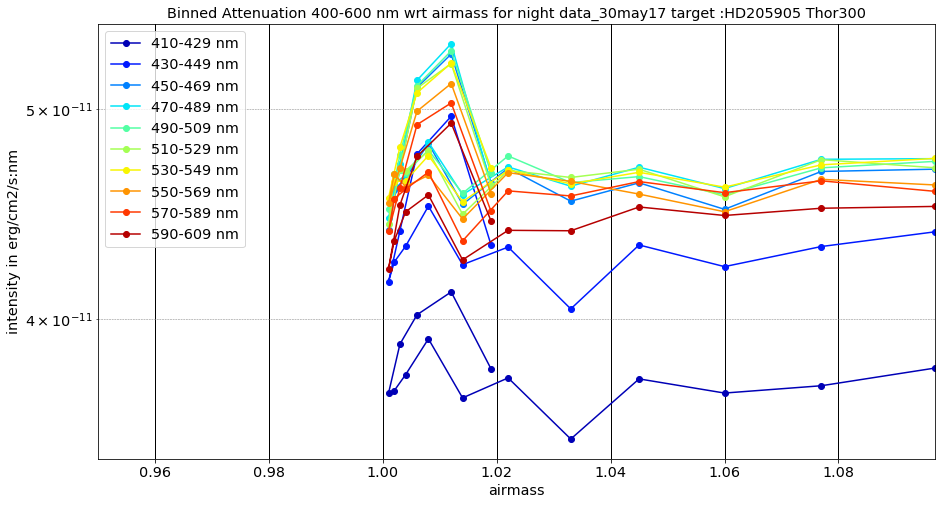

In [396]:
PlotSpectraDataSimAttenuationSmoothBin(all_spectrafiles,sel_obs_Thor300,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=0.95,XMAX=0,YMIN=0,YMAX=0,ZMIN=400,ZMAX=600,Wwidth=21,Bwidth=20)   

In [397]:
thetitle="Binned Attenuation 600-1000 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Thor300"

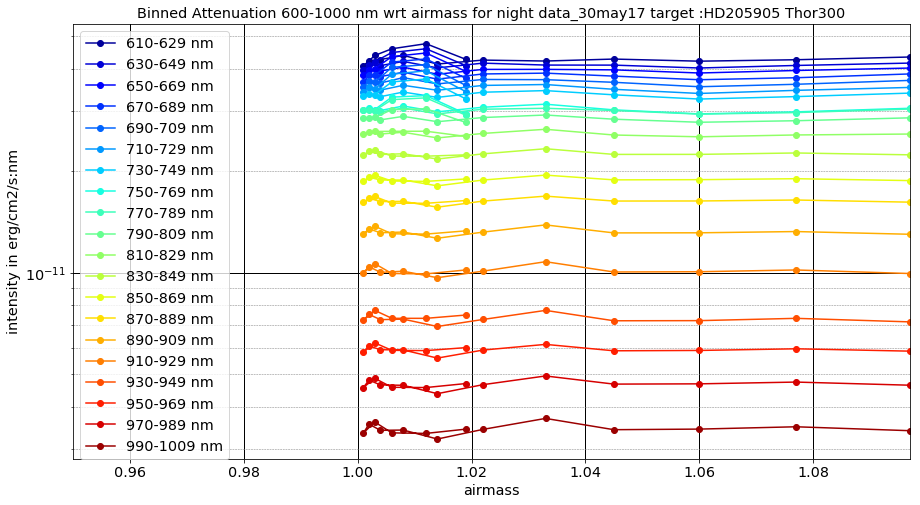

In [398]:
PlotSpectraDataSimAttenuationSmoothBin(all_spectrafiles,sel_obs_Thor300,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=0.95,XMAX=0,YMIN=0,YMAX=0,ZMIN=600,ZMAX=1000,Wwidth=21,Bwidth=20)   

## HoloPhP

In [399]:
thetitle="Attenuation 400-600 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloPhP"

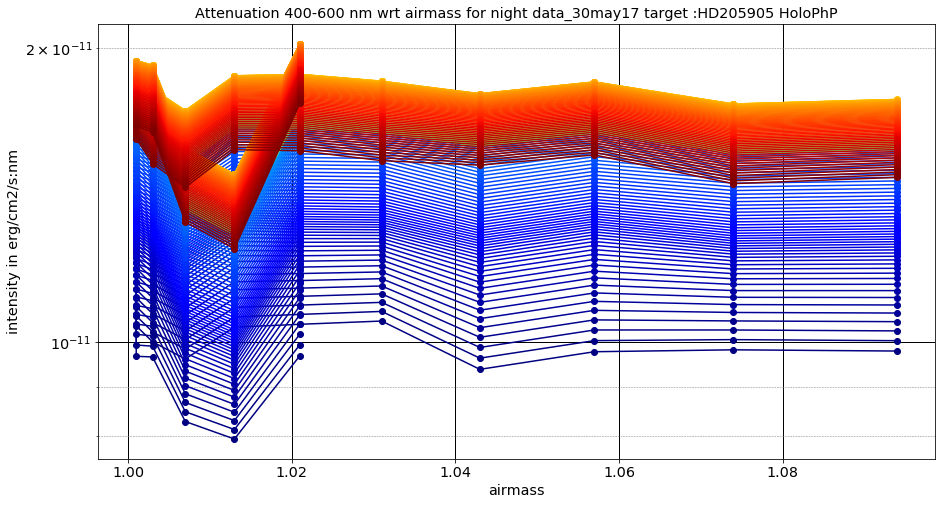

In [400]:
PlotSpectraDataSimAttenuationSmooth(all_spectrafiles,sel_obs_HoloPhP,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=400,XMAX=1000.,YMIN=0,YMAX=0,ZMIN=400,ZMAX=600,Wwidth=51)   

In [401]:
thetitle="Binned Attenuation 400-600 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloPhP"

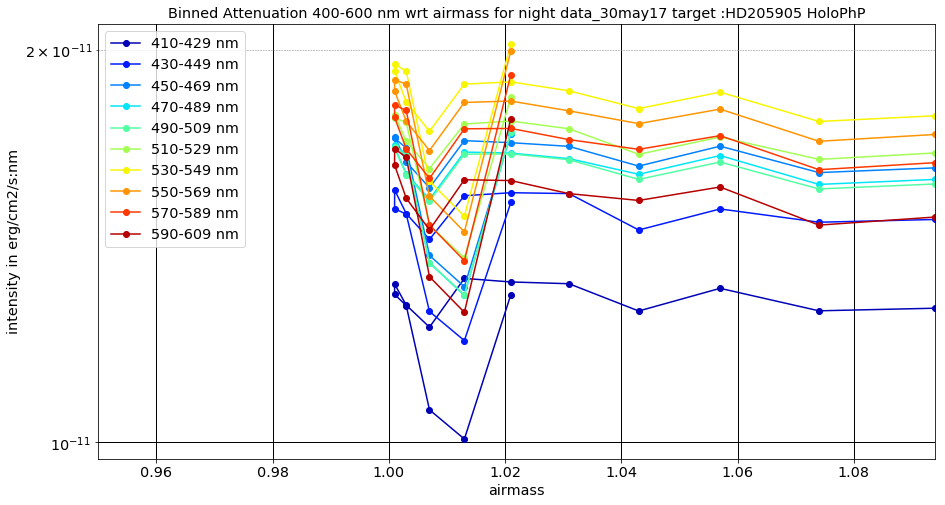

In [402]:
PlotSpectraDataSimAttenuationSmoothBin(all_spectrafiles,sel_obs_HoloPhP,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=0.95,XMAX=0,YMIN=0,YMAX=0,ZMIN=400,ZMAX=600,Wwidth=21,Bwidth=20)   

In [403]:
thetitle="Binned Attenuation 600-1000 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloPhP"

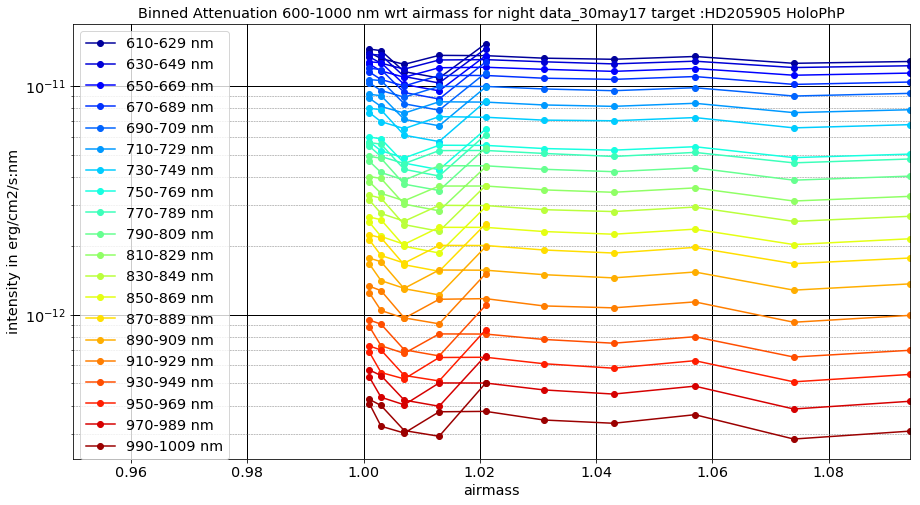

In [404]:
PlotSpectraDataSimAttenuationSmoothBin(all_spectrafiles,sel_obs_HoloPhP,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=0.95,XMAX=0,YMIN=0,YMAX=0,ZMIN=600,ZMAX=1000,Wwidth=21,Bwidth=20)   

## HoloPhAg

In [405]:
thetitle="Attenuation 400-600 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloPhAg"

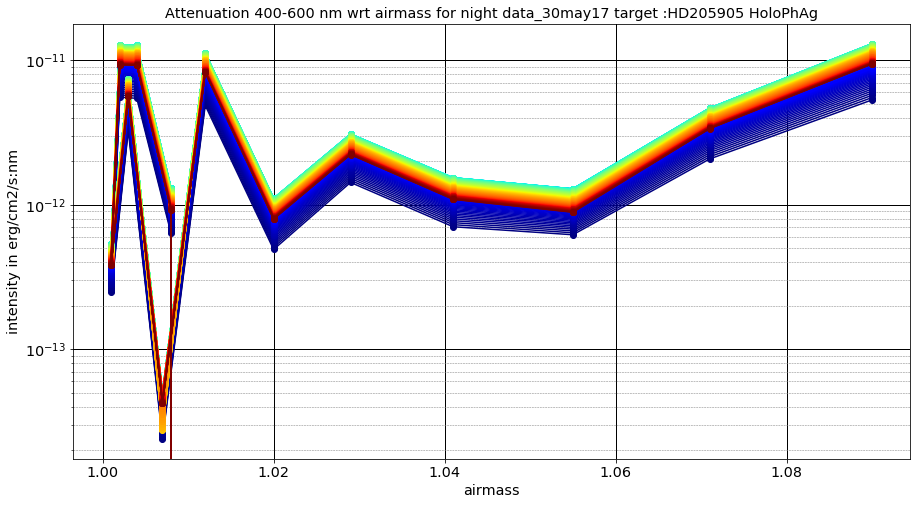

In [406]:
PlotSpectraDataSimAttenuationSmooth(all_spectrafiles,sel_obs_HoloPhAg,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=400,XMAX=1000.,YMIN=0,YMAX=0,ZMIN=400,ZMAX=600,Wwidth=51)   

In [407]:
thetitle="Binned Attenuation 400-600 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloPhAg"

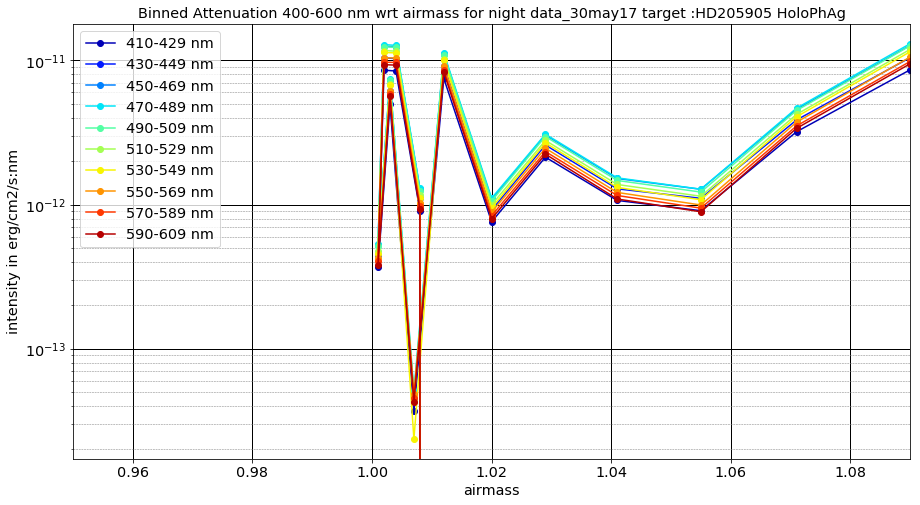

In [408]:
PlotSpectraDataSimAttenuationSmoothBin(all_spectrafiles,sel_obs_HoloPhAg,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=0.95,XMAX=0,YMIN=0,YMAX=0,ZMIN=400,ZMAX=600,Wwidth=21,Bwidth=20)   

In [409]:
thetitle="Binned Attenuation 600-1000 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloPhAg"

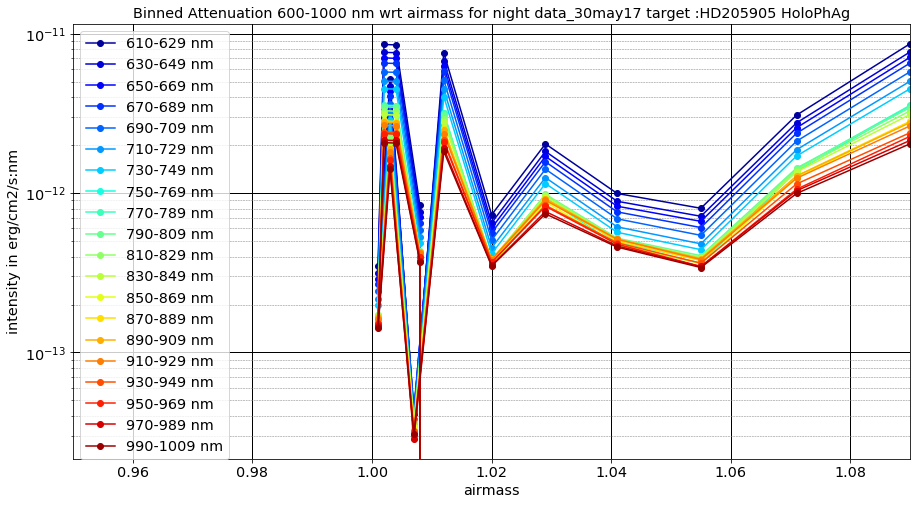

In [410]:
PlotSpectraDataSimAttenuationSmoothBin(all_spectrafiles,sel_obs_HoloPhAg,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=0.95,XMAX=0,YMIN=0,YMAX=0,ZMIN=600,ZMAX=1000,Wwidth=21,Bwidth=20)   

## HoloAmAg

In [411]:
thetitle="Attenuation 400-600 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloAmAg"

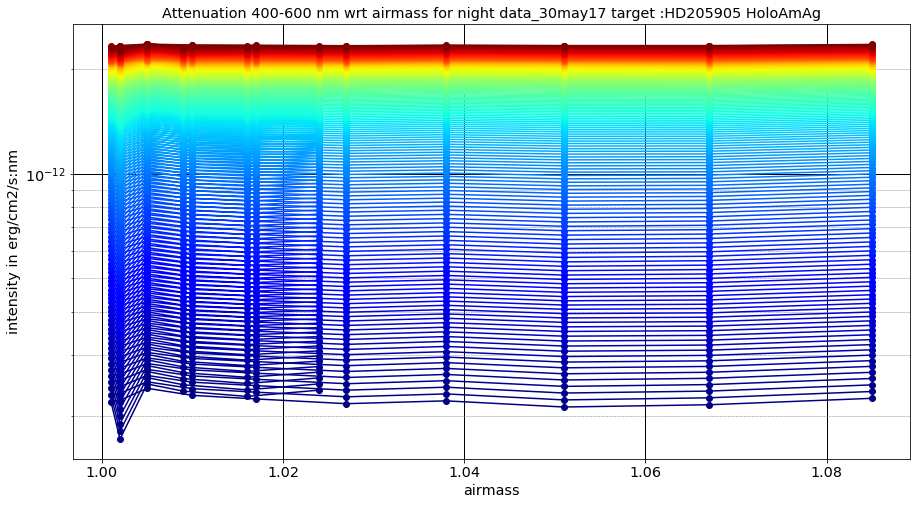

In [412]:
PlotSpectraDataSimAttenuationSmooth(all_spectrafiles,sel_obs_HoloAmAg,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=400,XMAX=1000.,YMIN=0,YMAX=0,ZMIN=400,ZMAX=600,Wwidth=51)   

In [413]:
thetitle="Binned Attenuation 400-600 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloAmAg"

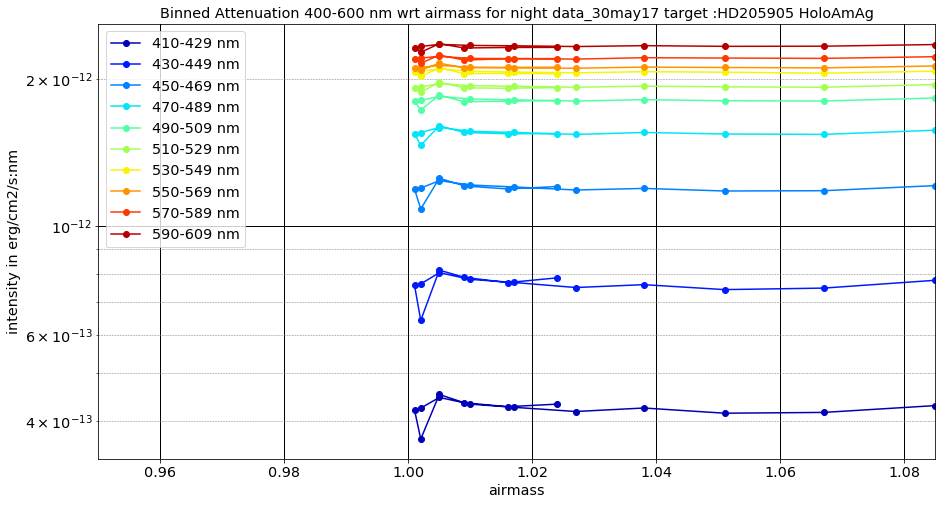

In [414]:
PlotSpectraDataSimAttenuationSmoothBin(all_spectrafiles,sel_obs_HoloAmAg,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=0.95,XMAX=0,YMIN=0,YMAX=0,ZMIN=400,ZMAX=600,Wwidth=21,Bwidth=20)   

In [415]:
thetitle="Binned Attenuation 600-1000 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloAmAg"

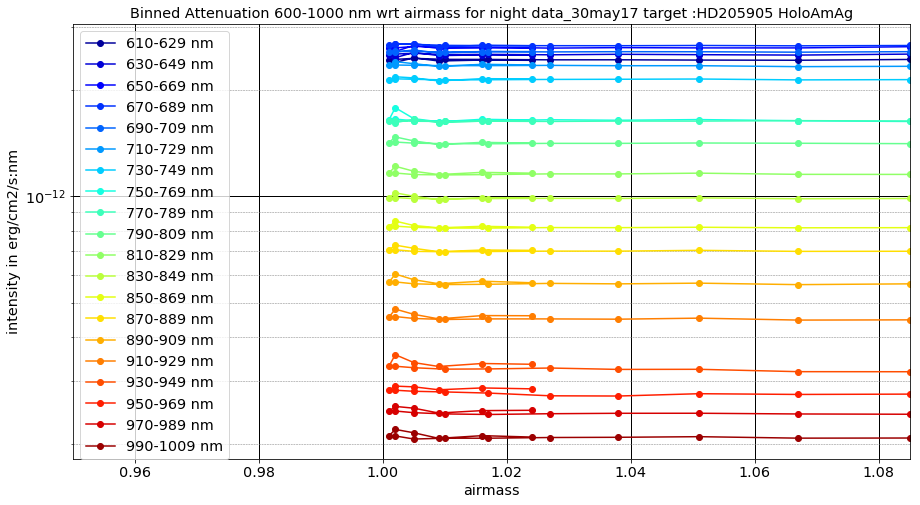

In [416]:
PlotSpectraDataSimAttenuationSmoothBin(all_spectrafiles,sel_obs_HoloAmAg,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=0.95,XMAX=0,YMIN=0,YMAX=0,ZMIN=600,ZMAX=1000,Wwidth=21,Bwidth=20)   

# Simulation

In [417]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [418]:
#SearchTagRe='^reduc_%s_([0-9]+)_spectrum.fits$' % (date)
SearchTagRe='^specsim_%s_([0-9]+)_spectrum.fits$' % (date)

## Simulation with ClearSky

In [419]:
thetitle="Attenuation 400-600 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Simulation ClearSky"

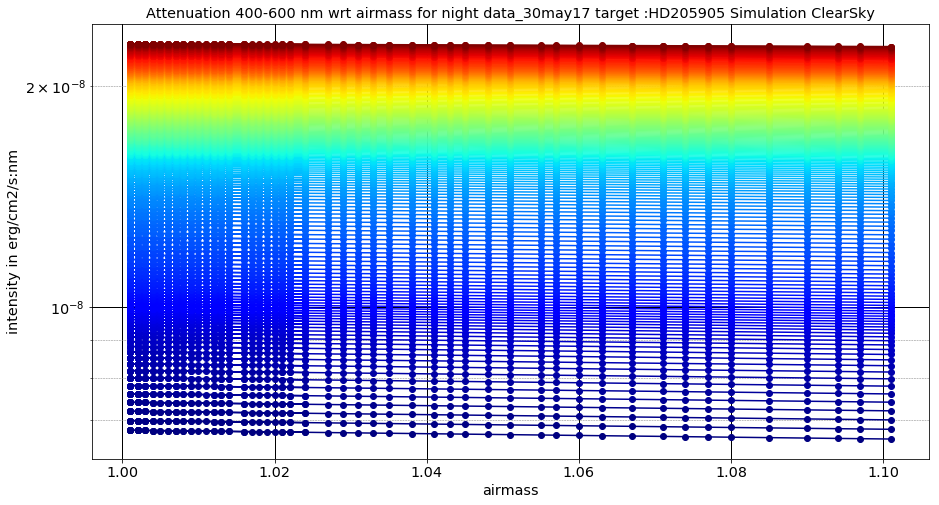

In [420]:
PlotSpectraDataSimAttenuationSmooth(all_simspectrafiles1,sel2_obs,SearchTagRe,np.zeros(len(wlshift)),thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=False,XMIN=400,XMAX=1000.,YMIN=0,YMAX=0,ZMIN=400,ZMAX=600,Wwidth=51)   

In [421]:
thetitle="Attenuation 600-1000 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Simulation ClearSky"

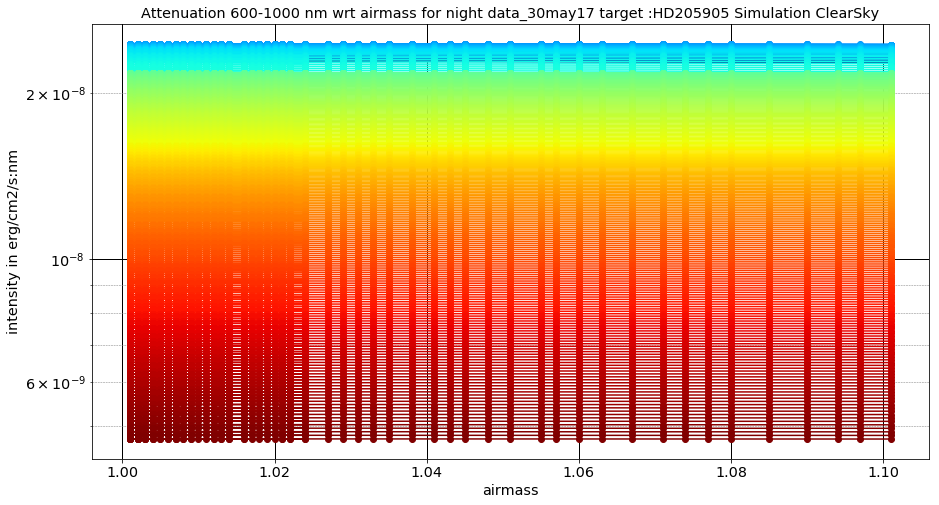

In [422]:
PlotSpectraDataSimAttenuationSmooth(all_simspectrafiles1,sel2_obs,SearchTagRe,np.zeros(len(wlshift)),thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=False,XMIN=0,XMAX=0,YMIN=0,YMAX=0,ZMIN=600,ZMAX=1000,Wwidth=51)   

In [423]:
thetitle="Binned Attenuation 400-600 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Simulation ClearSky"

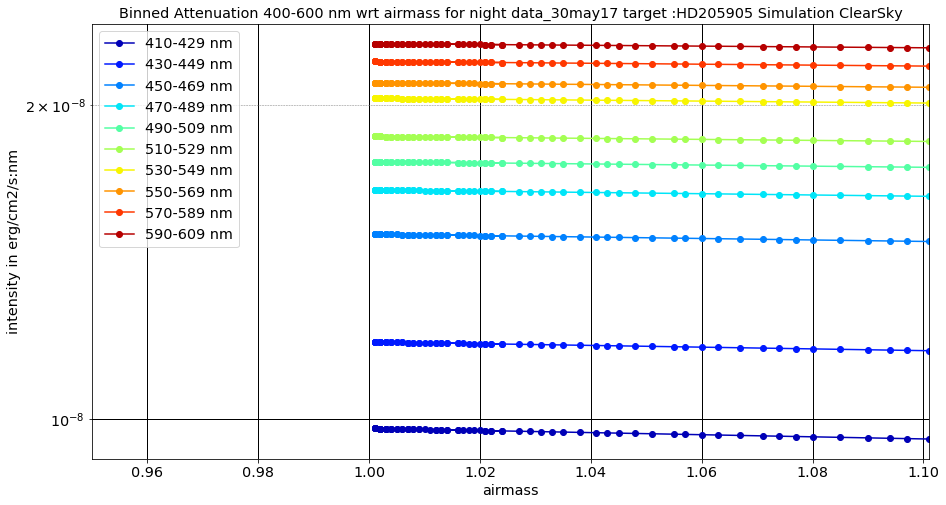

In [424]:
PlotSpectraDataSimAttenuationSmoothBin(all_simspectrafiles1,sel2_obs,SearchTagRe,np.zeros(len(wlshift)),thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=False,XMIN=0.95,XMAX=0,YMIN=0,YMAX=0,ZMIN=400,ZMAX=600,Wwidth=21,Bwidth=20) 

In [425]:
thetitle="Binned Attenuation 600-1000 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Simulation ClearSky"

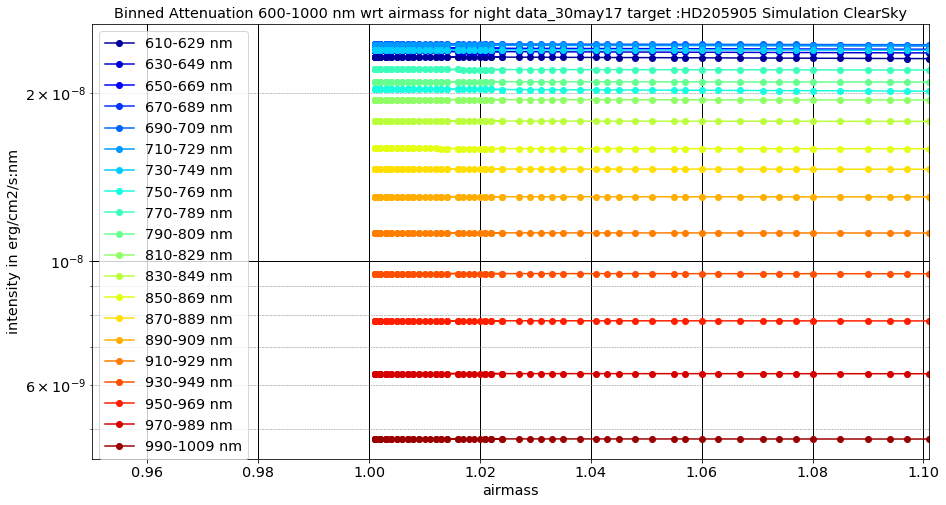

In [426]:
PlotSpectraDataSimAttenuationSmoothBin(all_simspectrafiles1,sel2_obs,SearchTagRe,np.zeros(len(wlshift)),thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=False,XMIN=0.95,XMAX=0,YMIN=0,YMAX=0,ZMIN=600,ZMAX=1000,Wwidth=21,Bwidth=20) 

## Simulation with average Sky

In [427]:
thetitle="Binned Attenuation 400-600 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Simulation Average Sky"

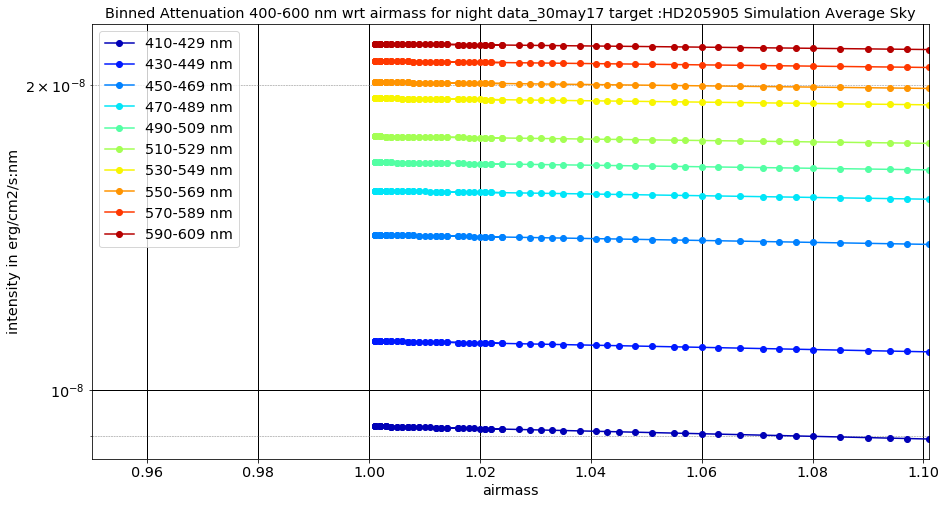

In [428]:
PlotSpectraDataSimAttenuationSmoothBin(all_simspectrafiles2,sel2_obs,SearchTagRe,np.zeros(len(wlshift)),thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=False,XMIN=0.95,XMAX=0,YMIN=0,YMAX=0,ZMIN=400,ZMAX=600,Wwidth=21,Bwidth=20) 

In [429]:
thetitle="Binned Attenuation 600-1000 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Simulation Average Sky"

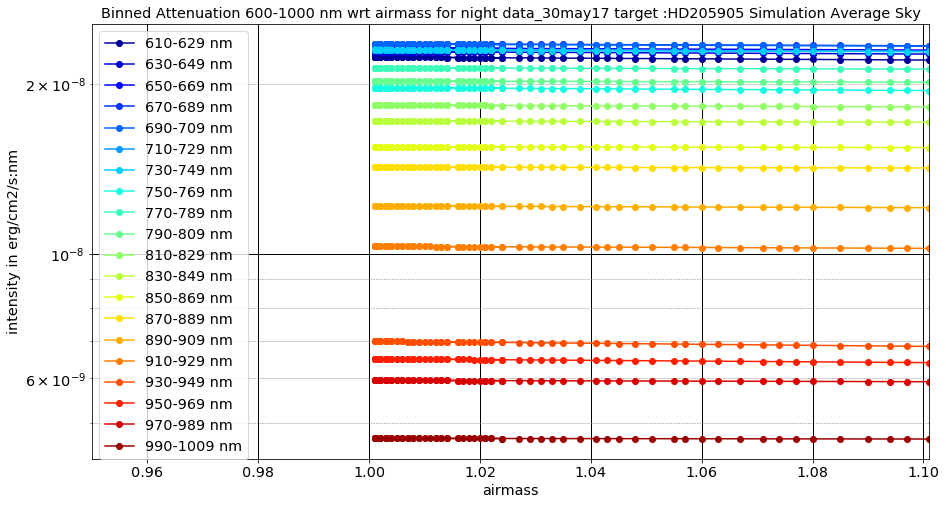

In [430]:
PlotSpectraDataSimAttenuationSmoothBin(all_simspectrafiles2,sel2_obs,SearchTagRe,np.zeros(len(wlshift)),thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=False,XMIN=0.95,XMAX=0,YMIN=0,YMAX=0,ZMIN=600,ZMAX=1000,Wwidth=21,Bwidth=20) 

## Simulation with MERRA2 Sky

In [431]:
thetitle="Binned Attenuation 400-600 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Simulation MERRA2 Sky"

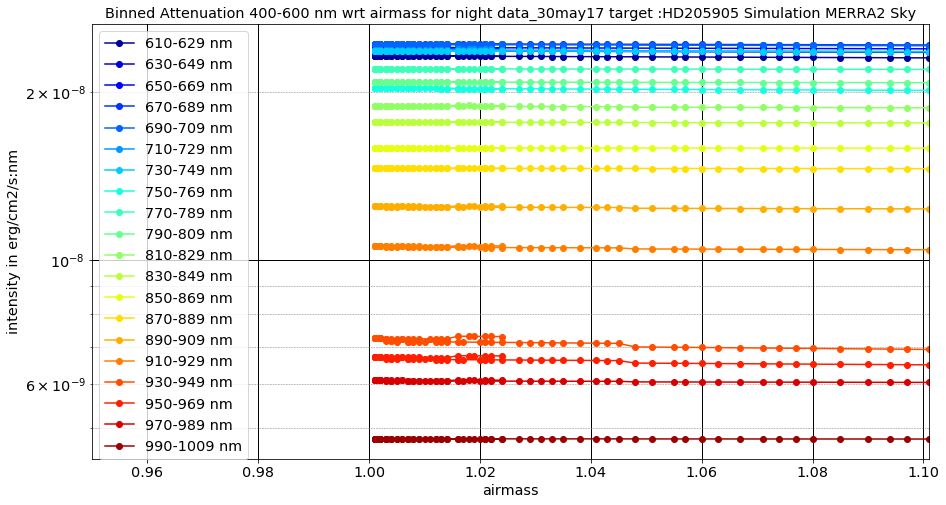

In [432]:
PlotSpectraDataSimAttenuationSmoothBin(all_simspectrafiles3,sel2_obs,SearchTagRe,np.zeros(len(wlshift)),thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=False,XMIN=0.95,XMAX=0,YMIN=0,YMAX=0,ZMIN=600,ZMAX=1000,Wwidth=21,Bwidth=20) 